# Introduction to Cartograms with pycartogram

This tutorial introduces **cartograms** and demonstrates how to create them using the `pycartogram` package. We'll use Berlin postal code districts as our example, creating cartograms from synthetic population data.

## What is a Cartogram?

A **cartogram** is a map where the size of regions is distorted to represent a variable other than geographic area. Instead of showing physical size, regions are scaled according to a quantity like population, GDP, or votes.

The algorithm used by `pycartogram` is the **diffusion-based cartogram** method developed by [Gastner and Newman (2004)](http://www.pnas.org/cgi/content/abstract/101/20/7499). It works by:

1. Converting the density data to a regular grid
2. Simulating diffusion of the density field until it becomes uniform
3. Tracking how each grid cell moves during diffusion
4. Applying the same displacement to polygon boundaries

The result is a smoothly deformed map where region areas are proportional to their density values.

## What You'll Learn

1. **Loading geographic data** from shapefiles
2. **Creating a `WardCartogram`** from polygon regions
3. **Computing density** from point locations
4. **Visualizing** original and transformed maps
5. **Comparing `WardCartogram` vs `PointCartogram`** approaches

## Setup

First, let's import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from colorsys import hsv_to_rgb

# Cartopy for geographic projections (optional but recommended for real geo data)
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader

# Shapely for geometry operations
from shapely.geometry import Polygon

# pycartogram
import pycartogram
from pycartogram import WardCartogram, PointCartogram

%matplotlib inline
print(f"pycartogram version: {pycartogram.__version__}")

pycartogram version: 0.1.0


## 1. Loading Geographic Data

We'll use a shapefile of Berlin's postal code districts ("Postleitzahlen"). The shapefile contains polygons in WGS84 (latitude/longitude) coordinates, which we'll project to UTM zone 33N for better distance preservation.

**Why project the coordinates?**
- Lat/lon coordinates are angular and don't preserve area well
- UTM is a metric projection suitable for regional maps
- Cartograms work best with projected coordinates

In [2]:
def load_and_project_shapefile(shapefile_path):
    """
    Load a shapefile and project from WGS84 to UTM zone 33N.
    
    Parameters
    ----------
    shapefile_path : str
        Path to the .shp file
    
    Returns
    -------
    list of Polygon
        Projected polygon geometries
    """
    # Read geometries from shapefile
    shape_data = [
        geom[0] if hasattr(geom, '__getitem__') else geom
        for geom in Reader(shapefile_path).geometries()
    ]
    
    # Define coordinate systems
    source_proj = ccrs.PlateCarree()  # WGS84 lat/lon
    target_proj = ccrs.UTM(zone=33, southern_hemisphere=False)  # UTM 33N
    
    # Project each polygon
    projected_polygons = []
    for geom in shape_data:
        # Transform each coordinate
        projected_coords = [
            target_proj.transform_point(x, y, source_proj)
            for x, y in geom.exterior.coords
        ]
        projected_polygons.append(Polygon(projected_coords))
    
    return projected_polygons

# Load Berlin postal code districts
berlin_wards = load_and_project_shapefile('../data/berlin_postleitzahlen.shp')

print(f"Loaded {len(berlin_wards)} postal code districts")
print(f"Example polygon has {len(berlin_wards[0].exterior.coords)} vertices")

Loaded 190 postal code districts
Example polygon has 11 vertices


Let's visualize the original Berlin postal code map:

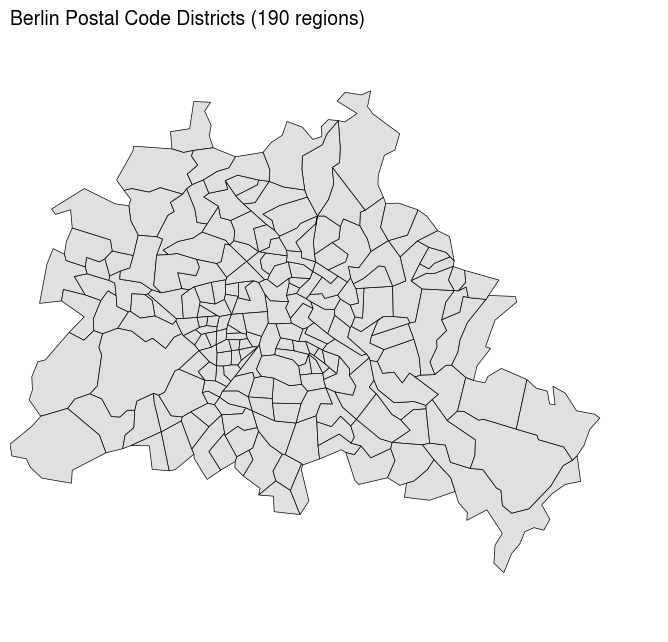

In [3]:
def plot_polygons(polygons, colors=None, edgecolor='k', linewidth=0.5, 
                  figsize=(10, 8), title=None, ax=None):
    """
    Plot a list of polygons.
    
    Parameters
    ----------
    polygons : list of Polygon
        Shapely polygons to plot
    colors : list or str, optional
        Face colors for each polygon
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    if colors is None:
        colors = ['#cccccc'] * len(polygons)
    elif isinstance(colors, str):
        colors = [colors] * len(polygons)
    
    for poly, color in zip(polygons, colors):
        x, y = poly.exterior.xy
        ax.fill(x, y, facecolor=color, edgecolor=edgecolor, linewidth=linewidth)
    
    ax.set_aspect('equal')
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=14)
    
    return fig, ax

# Plot original Berlin map
fig, ax = plot_polygons(berlin_wards, colors='#e0e0e0', 
                         title=f'Berlin Postal Code Districts ({len(berlin_wards)} regions)')
plt.show()

## 2. Creating a WardCartogram

The `WardCartogram` class is designed for data organized by regions ("wards"). It takes:

- **wards**: List of Shapely Polygon objects defining the regions
- **ward_density**: Density value for each ward (or `None` to compute later)
- **x_raster_size / y_raster_size**: Resolution of the computational grid
- **margin_ratio**: Extra margin around the bounding box (as a fraction of width)

Let's initialize a cartogram without density values first:

In [4]:
# Initialize the cartogram (without density values yet)
carto = WardCartogram(
    wards=berlin_wards,
    ward_density=None,  # We'll compute this from point locations
    x_raster_size=128,  # Grid resolution (higher = more detail but slower)
    y_raster_size=98,
    margin_ratio=0.2,   # 20% margin around the map
    map_orientation='landscape',
)

print(f"Cartogram initialized")
print(f"  Bounding box: {carto.orig_bbox.bounds}")
print(f"  Grid size: {carto.xsize} x {carto.ysize}")
print(f"  Original width: {carto.orig_width:.0f} meters")
print(f"  Original height: {carto.orig_height:.0f} meters")

Cartogram initialized
  Bounding box: (370000.5765859133, 5799572.5366464155, 415452.8153643912, 5836705.102286859)
  Grid size: 128 x 98
  Original width: 45452 meters
  Original height: 37133 meters


## 3. Generating Synthetic Population Data

For this example, we'll create synthetic "population" data using an exponential distribution. This simulates a scenario where population is concentrated in the south of Berlin (like a city center) and decreases toward the north.

In real applications, you would use actual location data (e.g., addresses, GPS coordinates).

In [5]:
def generate_exponential_points(carto, n_points=10000, seed=42):
    """
    Generate random points with exponential distribution in y-direction.
    
    This simulates population concentrated in the southern part of the map,
    decreasing exponentially toward the north.
    """
    np.random.seed(seed)
    
    # Get bounding box
    xmin, ymin, xmax, ymax = carto.orig_bbox.bounds
    
    # Generate uniform x-coordinates
    x_coords = np.random.uniform(xmin, xmax, n_points)
    
    # Generate exponentially distributed y-coordinates
    # (concentrated at the bottom, decreasing upward)
    mean_height = carto.orig_height * 0.2  # Scale parameter
    y_offsets = np.random.exponential(mean_height, n_points)
    
    # Clip values that exceed the height to random positions
    out_of_bounds = y_offsets > carto.orig_height
    y_offsets[out_of_bounds] = np.random.uniform(0, carto.orig_height, out_of_bounds.sum())
    y_coords = ymin + y_offsets
    
    return np.column_stack([x_coords, y_coords])

# Generate 10,000 synthetic population points
points = generate_exponential_points(carto, n_points=10000)

print(f"Generated {len(points)} synthetic location points")
print(f"  X range: {points[:, 0].min():.0f} to {points[:, 0].max():.0f}")
print(f"  Y range: {points[:, 1].min():.0f} to {points[:, 1].max():.0f}")

Generated 10000 synthetic location points
  X range: 370001 to 415440
  Y range: 5799574 to 5836605


Let's visualize the point distribution on the map:

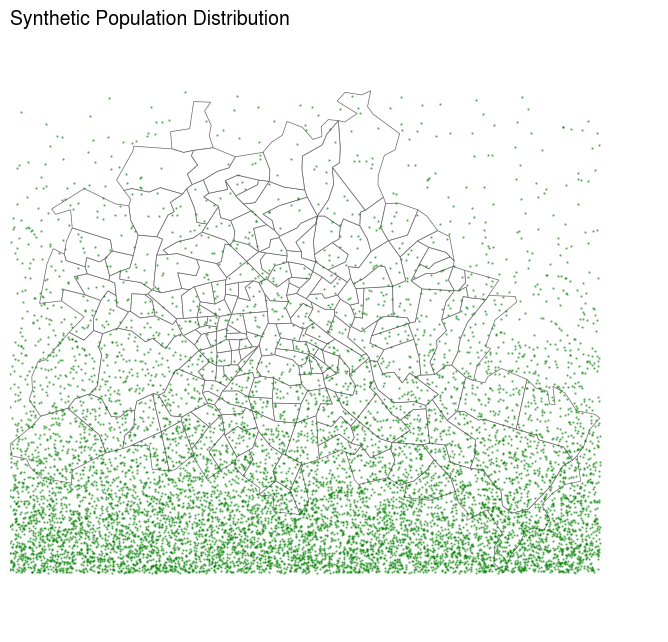

In [6]:
fig, ax = plot_polygons(berlin_wards, colors='white', edgecolor='#666666',
                         title='Synthetic Population Distribution')
ax.scatter(points[:, 0], points[:, 1], s=0.5, c='green', alpha=0.5)
plt.show()

## 4. Computing Ward Densities

Now we need to convert the point locations to **density values per ward**. The `WardCartogram` can do this automatically by:

1. Counting how many points fall within each ward
2. Dividing by the ward's area to get a density

This is the key step: wards with more points per unit area will expand in the cartogram.

In [7]:
# Compute density from point locations
# This counts points in each ward and divides by area
carto.compute_ward_density_from_locations(points, verbose=True)

print(f"\nWard density statistics:")
print(f"  Min density: {min(carto.ward_density):.2e}")
print(f"  Max density: {max(carto.ward_density):.2e}")
print(f"  Density ratio (max/min): {max(carto.ward_density)/min(carto.ward_density):.1f}x")

computing ward densities: 100%|██████████████████████████████████████████████████████████| 3599/3599 [00:00<00:00, 6165.83it/s]


Ward density statistics:
  Min density: 0.00e+00
  Max density: 1.68e-05
  Density ratio (max/min): infx



/var/folders/lk/6xn0tp_j2hz9nj1g893krwj80000gn/T/ipykernel_69956/1680464339.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  Density ratio (max/min): {max(carto.ward_density)/min(carto.ward_density):.1f}x")


## 5. Computing the Cartogram

Now we run the cartogram algorithm. This:

1. Rasterizes the ward densities onto a regular grid
2. Runs the diffusion algorithm to compute the deformation field
3. Transforms the ward boundaries using the deformation

In [8]:
# Compute the cartogram transformation
carto.compute(verbose=True);

cast density to matrix: 100%|██████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 4697.40it/s]



computing cartogram...


  100%  |==================================================|
transforming wards: 100%|██████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 2455.83it/s]


## 6. Visualizing the Results

Let's compare the original map with the cartogram. We'll use harmonious colors to make the visualization more appealing.

In [9]:
def random_harmonious_colors(n, saturation=0.5, value=0.85, seed=None):
    """
    Generate n random colors with consistent saturation and brightness.
    
    Using HSV color space with fixed saturation and value ensures
    all colors have similar visual intensity.
    """
    if seed is not None:
        np.random.seed(seed)
    hues = np.random.random(n)
    return [hsv_to_rgb(h, saturation, value) for h in hues]

# Generate colors for the wards
ward_colors = random_harmonious_colors(len(berlin_wards), 
                                         saturation=0.45, value=0.9, seed=42)

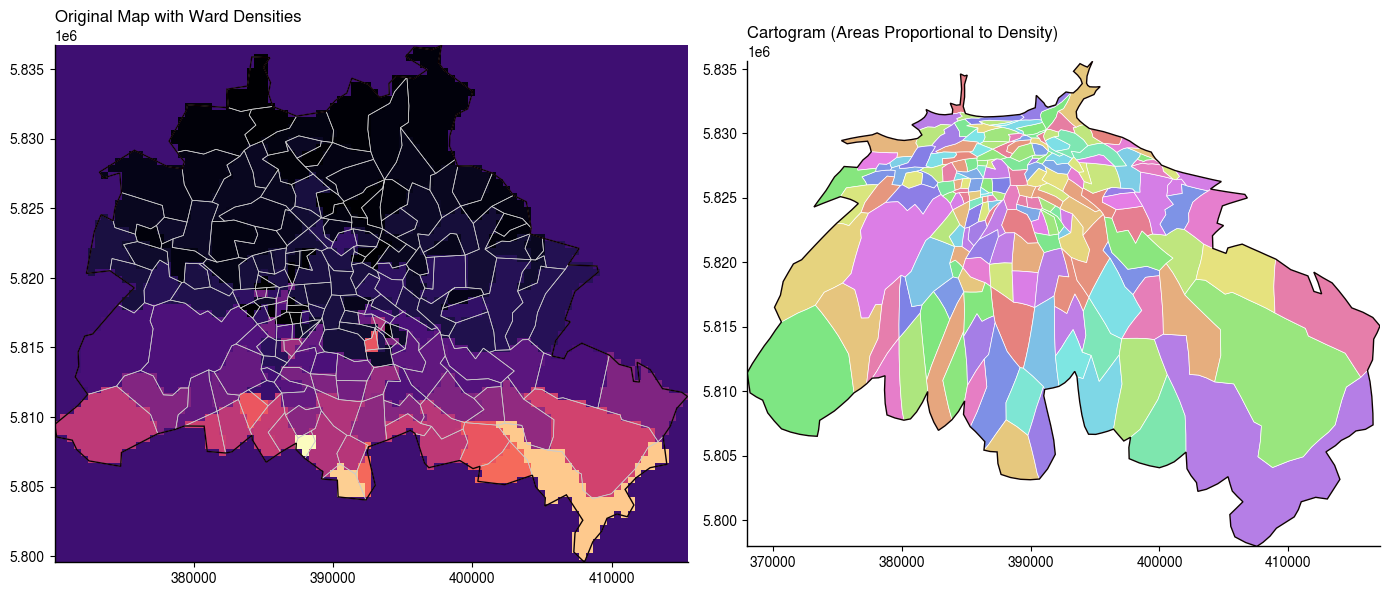

In [10]:
# Compare original and cartogram side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original map with density visualization
carto.plot(
    show_new_wards=False,  # Don't show transformed wards
    show_density_matrix=True,  # Show the density heatmap
    edge_colors='#cccccc',
    ax=axes[0]
)
axes[0].set_title('Original Map with Ward Densities', fontsize=12)

# Cartogram
carto.plot(
    ward_colors=ward_colors,
    edge_colors='white',
    ax=axes[1]
)
axes[1].set_title('Cartogram (Areas Proportional to Density)', fontsize=12)

plt.tight_layout()
plt.show()

### Detailed Comparison

Let's create a more detailed view showing all stages of the process:

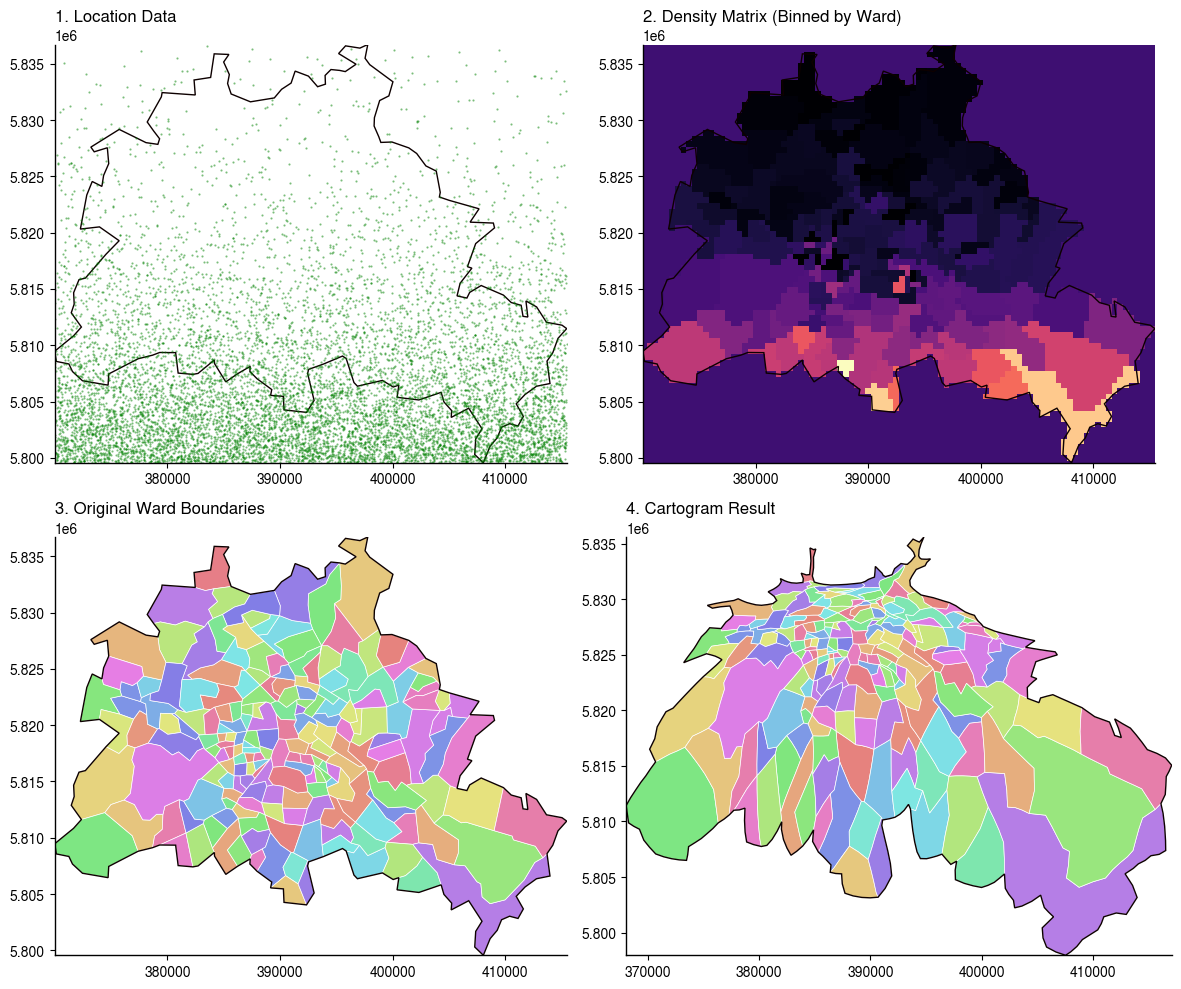

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Original map with points
carto.plot(
    show_new_wards=False,
    show_density_matrix=False,
    ward_colors='white',
    ax=axes[0, 0]
)
axes[0, 0].scatter(points[:, 0], points[:, 1], s=0.3, c='green', alpha=0.5)
axes[0, 0].set_title('1. Location Data', fontsize=12)

# 2. Density matrix
carto.plot(
    show_new_wards=False,
    show_density_matrix=True,
    ax=axes[0, 1]
)
axes[0, 1].set_title('2. Density Matrix (Binned by Ward)', fontsize=12)

# 3. Original wards (colored)
carto.plot(
    show_new_wards=False,
    ward_colors=ward_colors,
    edge_colors='white',
    ax=axes[1, 0]
)
axes[1, 0].set_title('3. Original Ward Boundaries', fontsize=12)

# 4. Cartogram
carto.plot(
    ward_colors=ward_colors,
    edge_colors='white',
    ax=axes[1, 1]
)
axes[1, 1].set_title('4. Cartogram Result', fontsize=12)

plt.tight_layout()
plt.show()

**Interpretation:**

- The **southern wards** (bottom of the map) where population is concentrated have **expanded**
- The **northern wards** with fewer points have **shrunk**
- The overall shape is preserved but distorted to reflect the density distribution

## 7. Alternative: PointCartogram

While `WardCartogram` bins points by ward boundaries, `PointCartogram` uses a **pixel-based** binning approach. This can produce smoother results when:

- Wards are very different sizes
- You want higher resolution than the ward boundaries allow
- You don't have ward boundaries, just a bounding polygon

Let's compare the two approaches:

In [12]:
# Get the overall Berlin boundary (union of all wards)
berlin_boundary = carto.whole_shape

# Create a PointCartogram
carto_point = PointCartogram(
    points=points,
    wards=[berlin_boundary],  # Just the outer boundary
    x_raster_size=128,
    y_raster_size=98,
    margin_ratio=0.2,
)

# Rasterize points to pixel density
carto_point.cast_density_to_matrix(verbose=True)

# Compute the cartogram
carto_point.compute(verbose=True)

# Transform the boundary
carto_point.transform_wards(verbose=True)

casting points to matrix: 100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 788328.92it/s]
    2%  |=                


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 269.47it/s]


[<POLYGON ((375447.95 5812641.48, 374805.766 5812602.505, 374272.107 5812579....>]

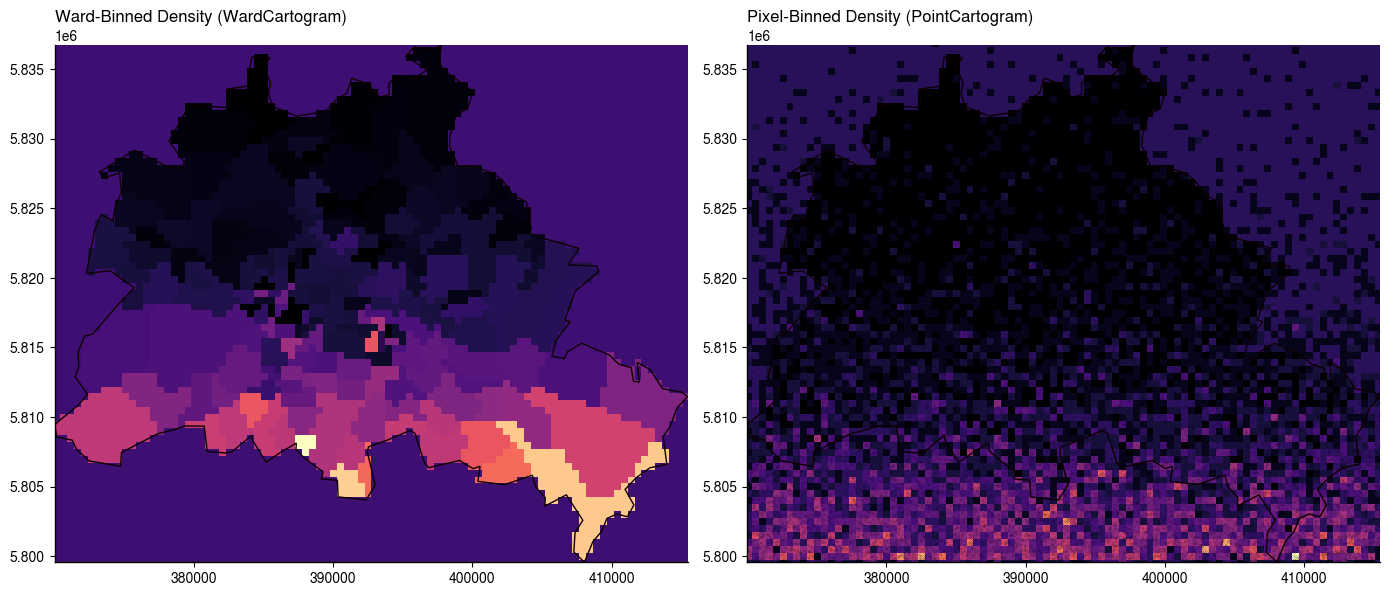

In [13]:
# Compare ward-binned vs pixel-binned density matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ward-binned density
carto.plot(
    show_new_wards=False,
    show_density_matrix=True,
    ax=axes[0]
)
axes[0].set_title('Ward-Binned Density (WardCartogram)', fontsize=12)

# Pixel-binned density
carto_point.plot_points(
    show_density_matrix=True,
    show_new_points=False,
    ax=axes[1],
    ms=0.2,
    mfc='green'
)
axes[1].set_title('Pixel-Binned Density (PointCartogram)', fontsize=12)

plt.tight_layout()
plt.show()

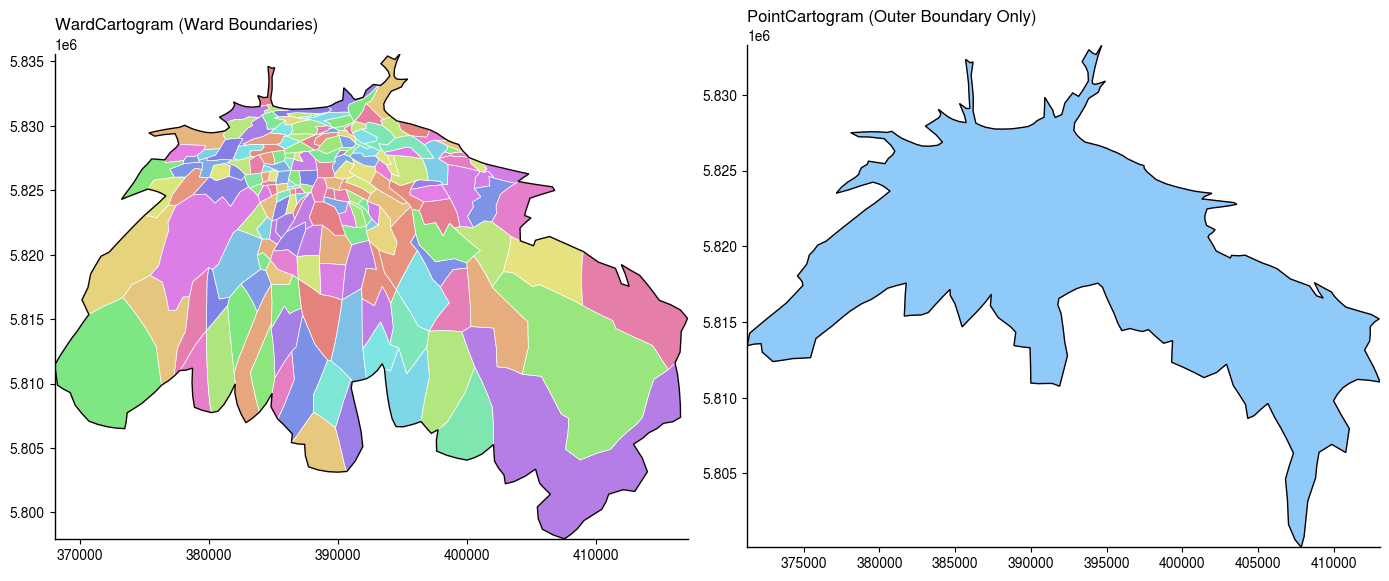

In [14]:
# Compare the final cartograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# WardCartogram result
carto.plot(
    ward_colors=ward_colors,
    edge_colors='white',
    ax=axes[0]
)
axes[0].set_title('WardCartogram (Ward Boundaries)', fontsize=12)

# PointCartogram result
carto_point.plot(
    ward_colors=['#90CAF9'],
    ax=axes[1]
)
axes[1].set_title('PointCartogram (Outer Boundary Only)', fontsize=12)

plt.tight_layout()
plt.show()

**Key Differences:**

| Feature | WardCartogram | PointCartogram |
|---------|--------------|----------------|
| Density binning | By ward boundaries | By pixels |
| Output | Transformed ward polygons | Transformed boundary + points |
| Best for | Administrative boundaries | Continuous data |
| Resolution | Limited by ward count | Limited by grid size |

## 8. Using Pre-defined Density Values

Instead of computing density from points, you can also provide density values directly. This is useful when you already have statistical data (e.g., census data, election results).

In [15]:
# Example: Create a cartogram with synthetic density values
# (e.g., this could be population or GDP per district)

np.random.seed(123)

# Generate random "population" values with some structure
synthetic_population = np.random.lognormal(mean=10, sigma=1, size=len(berlin_wards))

# Create cartogram with explicit density values
carto_explicit = WardCartogram(
    wards=berlin_wards,
    ward_density=synthetic_population,  # Pass density directly
    norm_density=True,  # Normalize to prevent extreme distortions
    x_raster_size=128,
    y_raster_size=98,
    margin_ratio=0.2,
)

carto_explicit.compute(verbose=True);

cast density to matrix: 100%|██████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 4700.78it/s]
  100%  |==================================================|



computing cartogram...


transforming wards: 100%|██████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 2482.30it/s]


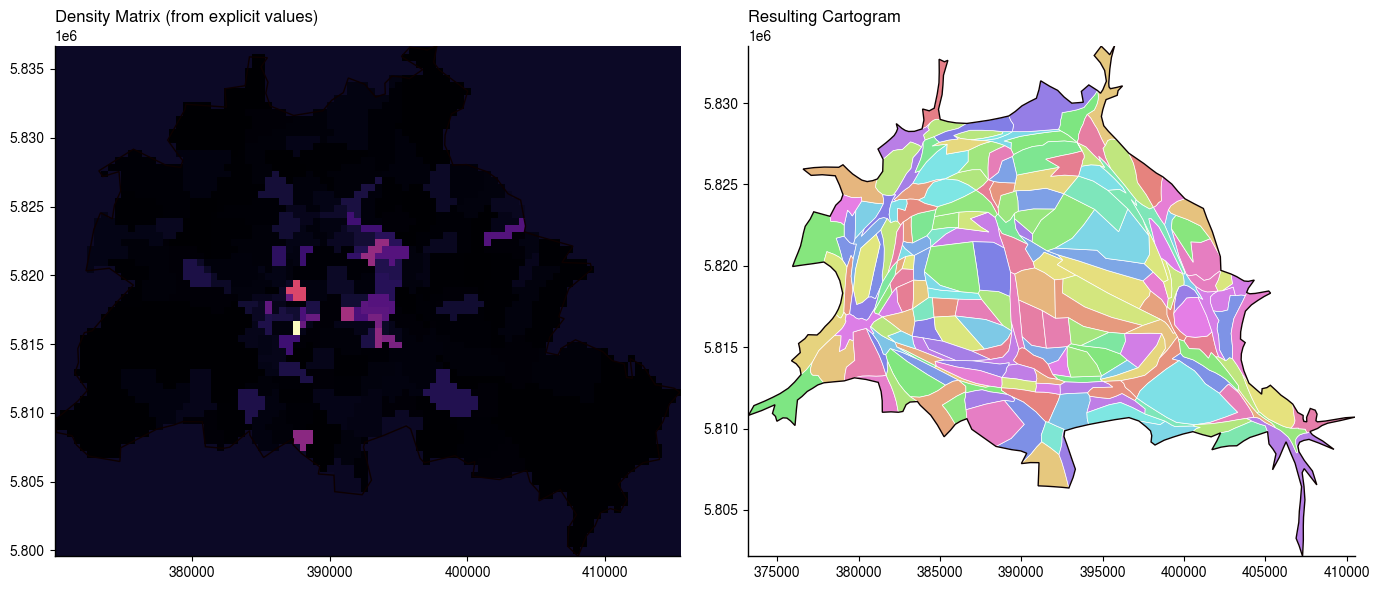

In [16]:
# Visualize the result
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

carto_explicit.plot(
    show_new_wards=False,
    show_density_matrix=True,
    ax=axes[0]
)
axes[0].set_title('Density Matrix (from explicit values)', fontsize=12)

carto_explicit.plot(
    ward_colors=ward_colors,
    edge_colors='white',
    ax=axes[1]
)
axes[1].set_title('Resulting Cartogram', fontsize=12)

plt.tight_layout()
plt.show()

## Summary

In this tutorial, we learned how to:

1. **Load geographic data** from shapefiles and project to a suitable coordinate system
2. **Create a `WardCartogram`** from polygon regions
3. **Compute density** from point locations or use explicit values
4. **Run the cartogram algorithm** to compute the transformation
5. **Visualize** the original map, density matrix, and transformed cartogram
6. **Compare approaches**: `WardCartogram` (ward-binned) vs `PointCartogram` (pixel-binned)

### Key Classes

| Class | Use Case |
|-------|----------|
| `WardCartogram` | Data organized by regions/boundaries |
| `PointCartogram` | Raw point data with optional boundary |
| `GeoDataFrameWardCartogram` | Direct GeoPandas integration |

### Next Steps

- Try the **GeoPandas example** (`party_cartograms_*.ipynb`) for a more complex workflow
- Explore **animated interpolation** with `get_interpolated_geo_df(t)`
- Experiment with different **grid resolutions** (`x_raster_size`, `y_raster_size`)